# Method: LSTM
# Dataset: Lorenz-96, F = 8
# Purpose: Uncertainty Quantification - Mean Variance Estimation

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [10]:
np.random.seed(1)
train.data = train.data + np.random.normal(0, 1e-1, train.data.shape)

In [11]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [5]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [6]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [7]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [12]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2, k3, k4 = jax.random.split(rng, num = 4)
        dO = W_init(k1, (data_dim, h_dim)) # weight matrix for mean
        db = b_init(k2, (data_dim,)) # bias for mean
        dV = W_init(k2, (1, h_dim))  # weight matrix for variance
        db2 = b_init(k3, (1,))       # bias for variance
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db, dV, db2
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db, dV, db2 = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = sigmoid(forget_gate * c + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            y2 = dV @ h_new + db2
            
            return (c_new, h_new), (y, y2)
        (c_final, h_final), (pred_traj, sigma) = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), (pred_traj[-1], sigma[-1])
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db, dV, db2 = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = sigmoid(forget_gate * cell + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            y2 = dV @ h_new + db2
            
            return (c_new, h_new, y), (y, y2)
        
        _, (pred_traj, sigma) = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj, sigma
    
    return init_fun, process, forecast

In [72]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1000.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(neg_log_LH)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, (preds, sigma) = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred, sigma_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)
            sigma_pred = jnp.concatenate([sigma[:, None,:], sigma_pred], axis=1)

            return y_pred, sigma_pred

        @jax.jit
        def neg_log_LH(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the negative log likelihood.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             neg log LH: negative log-likelihood of forecasts given inputs
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred, sigma_pred = make_forecast(params, x_batch, L_forecast)

            d = data_dim

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)

            constant = d * jnp.log(2 * jnp.pi)
            log_sigma = sigma_pred.mean()
            sigma = jnp.exp(log_sigma)
            sigma_loss = d * log_sigma

            return 0.5 * (constant + sigma_loss + (mu_loss / sigma**2))
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        overall_best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test//2 + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test//2)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(overall_best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train) # -ve log LH loss
                
                # validation             
                mse_val = neg_log_LH(params, x_val, y_val) # -ve log LH loss
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation Loss: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION LOSS")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [73]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, (preds, sigma) = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred, sigma_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)
        sigma_pred = jnp.concatenate([sigma[:, None,:], sigma_pred], axis=1)

        return y_pred, sigma_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         neg log LH: negative log-likelihood of forecasts given inputs

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred, sigma_pred = make_forecast(params, x_batch, L_forecast)

        #compute loss
        error = y_pred - y_truth
        mu_loss = jnp.mean(error**2)

        constant = d * jnp.log(2 * jnp.pi)
        log_sigma = sigma_pred.mean()
        sigma = jnp.exp(log_sigma)
        sigma_loss = d * log_sigma

        return 0.5 * (constant + sigma_loss + (mu_loss / sigma**2))
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred, log_sigma_pred = make_forecast(params, data_test, L_forecast_test)
    sigma_pred = jnp.exp(log_sigma_pred)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred), np.array(sigma_pred)[:,:,0]

In [74]:
def neg_log_LH(mean_pred, sd_pred):
    d = data_dim
    
    constant_loss = d * np.log(2 * np.pi)
    mu_loss = (mean_pred - y_test)**2
    if len(sd_pred.shape) == 2:
        sd_expanded = np.moveaxis(np.tile(sd_pred, (d, 1, 1)), 0, 2)# Repeat sd for each of the 40 dimensions 
    elif len(sd_pred.shape) == 3:
        sd_expanded = sd_pred
    else:
        raise Exception("Invalid sd_pred dimension")
    
    return 0.5 * (constant_loss + d * np.log(sd_expanded) + (mu_loss / sd_expanded**2)).mean(axis = (0, 2))

# 3. Best Parameters

In [75]:
nn_size = 500
L_forecast_train = 4
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [200, 200, 200]  # Number of epochs for each learning rate

seed = 42

In [76]:
res_folder = os.path.join("results", "mve_noise")

# 4. Mean Variance Estimation (Naive)

## 4.1 Training

In [77]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = seed, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.36 | Train loss = -22.2549267 | Val loss =  662.2661133
Epoch 20: Time taken = 2.44 | Train loss = -23.6416225 | Val loss =  646.0375977
Epoch 30: Time taken = 2.39 | Train loss = -24.4635181 | Val loss =  728.0964966
EARLY STOPPING. Epoch 33: Train loss = -24.6440430 | Val loss =  747.9428711
Best Validation Loss: 517.1129761
IMPROVED VALIDATION LOSS

Epoch 10: Time taken = 2.36 | Train loss = -22.8445377 | Val loss =  688.1055298
Epoch 20: Time taken = 2.32 | Train loss = -24.0044518 | Val loss =  760.5047607
Epoch 30: Time taken = 2.40 | Train loss = -24.6996937 | Val loss =  720.7547607
EARLY STOPPING. Epoch 32: Train loss = -24.7935162 | Val loss =  693.3567505
Best Validation Loss: 594.9640503

Epoch 10: Time taken = 2.40 | Train loss = -22.8318462 | Val loss =  638.8977051
Epoch 20: Time taken = 2.38 | Train loss = -24.0047150 | Val loss =  683.5692139
Epoch 30: Time taken = 2.40 | Train loss = -24.6854115 | Val loss =  677.8182983

In [78]:
save_obj(params, res_folder, "params.pkl")

## RELOAD DATA

In [79]:
# IF NEED TO RELOAD DATA
_, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
lstm_fx = (process_batch, forecast_batch)

params = load_obj(os.path.join(res_folder, "params.pkl"))

In [80]:
mean_pred, sd_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.90


## Variance

In [81]:
idx = 0

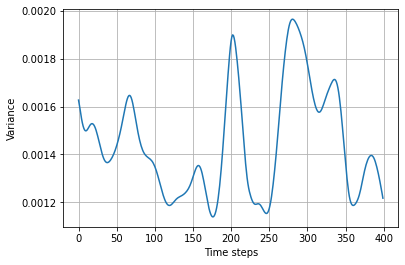

In [82]:
plt.plot(sd_pred[idx]**2)
plt.grid("on")
plt.xlabel("Time steps")
plt.ylabel("Variance")
plt.show()

## 4.2 MSE

In [83]:
desc_name = "lstm_nn" + str(nn_size) + "_mve"
res_mve = PointExperimentResult(mean_pred - y_test,
                                           desc_name)

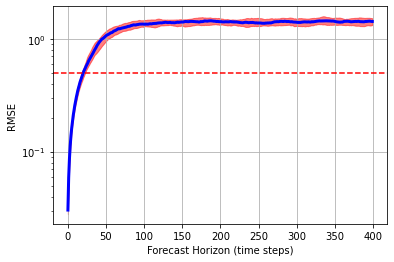

It takes around t = 0.21 for mean error to exceed 0.5


In [87]:
res_mve.plot_rmse(error_thresh = 0.5)

## 4.3 Negative Log LH

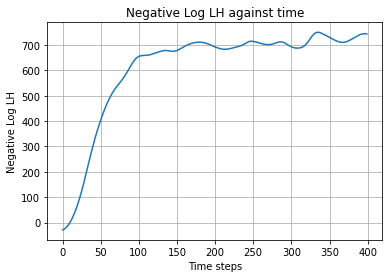

In [85]:
plt.plot(neg_log_LH(mean_pred, sd_pred))
plt.title("Negative Log LH against time")
plt.xlabel("Time steps")
plt.ylabel("Negative Log LH")
plt.grid("on")
plt.show()

In [86]:
print(f"Mean negative log LH: {neg_log_LH(mean_pred, sd_pred).mean():.5f}")

Mean negative log LH: 613.25094


# 5. Mean Variance Estimation (Sampling trajectories)

In [88]:
def get_test_pred_sampled(data_test, params, lstm_fx, seed):
    np.random.seed(seed)
    
    @partial(jax.jit, static_argnums=3)
    def make_forecast(params, hs, x_batch, horizon, first_sample):
        # compute the (L_forecast-1) next forecasts
        y_pred, sigma_pred = fbatch(params, hs, x_batch, horizon - 1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([first_sample[:, None,:], y_pred], axis=1)
        sigma_pred = jnp.concatenate([first_log_sigma[:, None,:], sigma_pred], axis=1)

        return y_pred, sigma_pred

    pbatch, fbatch = lstm_fx
    
    # GET INITIAL STEP
    hs, (first_pred, first_log_sigma) = pbatch(params, data_test)
    first_sigma = jnp.exp(first_log_sigma)
    
    all_traj_mean = []
    all_traj_sd = []
    for _ in range(N_TRAJ_MVE):
        first_sample = np.random.normal(first_pred, first_sigma)
        
        mean_traj, sigma_traj = make_forecast(params, hs, first_sample, L_forecast_test, first_sample)
        all_traj_mean.append(mean_traj)
        all_traj_sd.append(sigma_traj)
    return np.array(all_traj_mean), np.exp(all_traj_sd)

In [89]:
maa, saa = get_test_pred_sampled(X_test, params, lstm_fx, seed)

In [90]:
mve_s_mean = maa.mean(axis = 0)
mve_s_sigma = np.sqrt((saa**2 + maa**2).mean(axis = 0) - mve_s_mean**2)

## 5.1 Variance

**Visualise for one dataset**

In [91]:
idx = 0

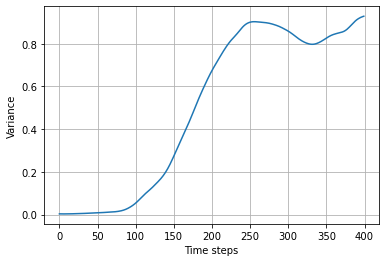

In [93]:
plt.plot(mve_s_sigma[idx].mean(axis = 1)**2)
plt.grid("on")
plt.xlabel("Time steps")
plt.ylabel("Variance")
plt.show()

## 5.2 MSE

In [94]:
desc_name = "lstm_nn" + str(nn_size) + "_mve_sampled"
res_mve = PointExperimentResult(mve_s_mean - y_test,
                                           desc_name)

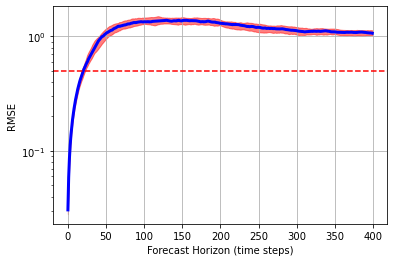

It takes around t = 0.21 for mean error to exceed 0.5


In [96]:
res_mve.plot_rmse(error_thresh = 0.5)

In [97]:
res_mve.get_loss([0.2, 0.5, 1, 2, 3])

Median NRMSE at t = 0.2: 0.499
Median NRMSE at t = 0.5: 1.063
Median NRMSE at t = 1: 1.344
Median NRMSE at t = 2: 1.302
Median NRMSE at t = 3: 1.123


## 5.3 Negative Log LH

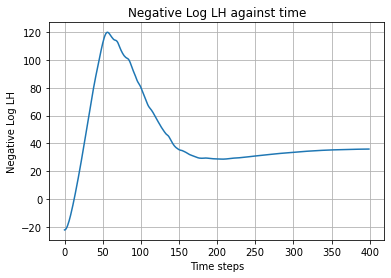

In [98]:
plt.plot(neg_log_LH(mve_s_mean, mve_s_sigma))
plt.title("Negative Log LH against time")
plt.xlabel("Time steps")
plt.ylabel("Negative Log LH")
# plt.yscale("log")
plt.grid("on")
plt.show()

In [99]:
print(f"Mean negative log LH: {neg_log_LH(mve_s_mean, mve_s_sigma).mean():.5f}")

Mean negative log LH: 45.10621
